Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## AS OF THE END DATE OF THE COURSE:  
A lot of time has been spent on cleaning, scrubbing, and understanding the organization of the data.   I had to generate some calculated features, and further projects include parsing the text fields.   


 

In [1]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

#import dataset
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 
# Two additional URLs which will be used:  i) LendingClub_07-12_Approved.csv
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"
#  
#                              iii) LendingClub_2014_Approved.csv

# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"

url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved_29MAY.csv"
lcd_raw = pd.read_csv(url,skiprows=1,
            parse_dates=['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'])

/Applications/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [2]:
lcd_raw.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
42533,72176,70868,2525,2525,225,36 months,9.33%,80.69,B,B3,...,0,2010-06-03,82.03,2010-07-03,2007-05-03,714,710,NaN,NaN,1
42534,71623,70735,6500,6500,0,36 months,8.38%,204.84,A,A5,...,0,2010-06-03,205.32,2010-07-03,2007-08-03,724,720,NaN,NaN,1
42535,70686,70681,5000,5000,0,36 months,7.75%,156.11,A,A3,...,0,2010-06-03,156.39,2010-07-03,2015-02-03,794,790,NaN,NaN,1
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [3]:
# Clean bottom of file and create new dataframe from it
lcd = lcd_raw[:-2].copy()

# Create Datetime fields from date information....
lcd = lcd.drop(lcd.index[lcd.last_pymnt_d == 'nan'])
lcd['last_pymnt_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.last_pymnt_d]
lcd['next_pymnt_date'] = [pd.to_datetime(j,format='%b-%Y', unit = "D") for j in lcd.next_pymnt_d]
lcd['last_credit_pull_date'] = [pd.to_datetime(j, unit = "D",format='%b-%Y') for j in lcd.last_credit_pull_d]
lcd['last_pymnt_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.last_pymnt_d]
lcd['issue_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.issue_d]


In [4]:
# Summarize the nulls in the data....
lcd.isnull().sum()

id                                 0
member_id                          1
loan_amnt                          1
funded_amnt                        1
funded_amnt_inv                    1
term                               1
int_rate                           1
installment                        1
grade                              1
sub_grade                          1
emp_title                       2625
emp_length                         1
home_ownership                     1
annual_inc                         5
verification_status                1
issue_d                            1
loan_status                        1
pymnt_plan                         1
url                                1
desc                           13293
purpose                            1
title                             13
zip_code                           1
addr_state                         1
dti                                1
delinq_2yrs                       30
earliest_cr_line                  30
f

In [5]:
# replace all Nan's for 'mnths_since_last_delinq',  with 999....this is a kludge for now.  If this feature is used in logistic
# Regression, we'll want to make sure its far away from the other real delinquencies...
lcd['mths_since_last_delinq'].fillna(value=999, inplace=True)
lcd['mths_since_last_record'].fillna(value=999,inplace=True)
# lcd['mths_since_last_delinq'].unique()

In [6]:
# Drop certain features we don't need for now, and create a new dataframe 
lcd.drop(['id','member_id','url', 'desc','title','emp_title','addr_state','zip_code',
                   'funded_amnt_inv','revol_bal','revol_util','out_prncp','out_prncp_inv','total_pymnt',
                   'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','collection_recovery_fee',
                   'last_fico_range_high','last_fico_range_low','initial_list_status','policy_code',
                   'earliest_cr_line'], axis=1,inplace=True)


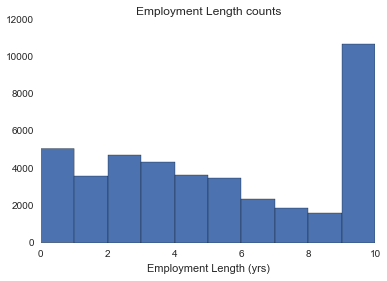

In [7]:
#  Convert Field Employment Length into a classifier
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

# Now graph
lcd['emp_length_numeric'].hist()
plt.title('Employment Length counts')
plt.xlabel('Employment Length (yrs)')

Employment length reasonably evenly distributed out to 5 years.    How is this distributed versus FICO score?

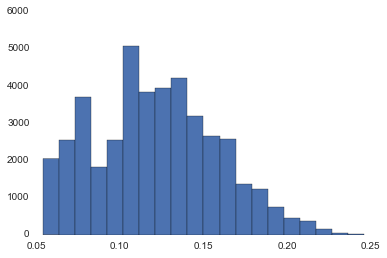

In [8]:
# Strip chars, convert int_rate series to float
lcd.int_rate.fillna(method='backfill',inplace = True)
lcd['clean_rates'] = [float(t.strip(' %'))/100 for t in lcd.int_rate]

# Now graph!
lcd['clean_rates'].hist(bins=20)

In [9]:
# clean term by splitting on spaces and converting numbers into float
lcd.term.fillna(method='backfill',inplace = True)
lcd['clean_term'] = [float (s.split(' ')[1]) for s in lcd.term]

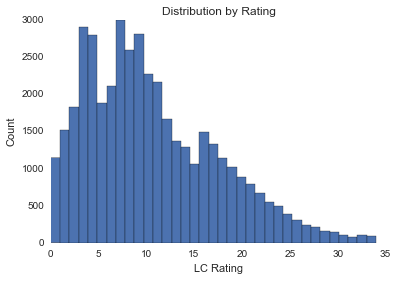

In [10]:
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

plt.xlabel('LC Rating')
plt.ylabel('Count')
plt.title('Distribution by Rating')
# X_Axis_Labels = ('A1','A2','A3','A4','A5','B1','B2','B3','B4','B5',
#                 'C1','C2','C3','C4','C5','D1','D2','D3','D4','D5',
#                 'E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
#                 'G1','G2','G3','G4','G5')
# x_axis = np.arange(len(X_Axis_Labels))
# plt.xticks(x_axis,X_Axis_Labels,rotation=90)
# plt.figure(figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
lcd['sub_grade_int'].hist(bins=35)                             

In [70]:
# print lcd['purpose'].unique() 
# ['credit_card' 'car' 'small_business' 'other' 'wedding'
#  'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
#  'moving' 'vacation' 'house' 'renewable_energy' 'educational']

In [11]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']

# backfill all NAs...in theory this might create some problems, but there aren't enough NAs to bias results. 
lcd['verification_status'].fillna(method='backfill',inplace = True)
lcd['verification_status_b'] = (lcd['verification_status']== 'VERIFIED - income') | (lcd['verification_status'] =='VERIFIED - income source')

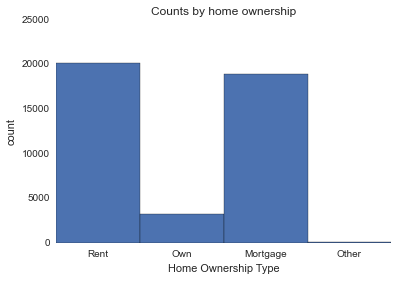

In [12]:
# Convert Home ownership into categorical variable and encode using One Hot Encoder

from sklearn.preprocessing import OneHotEncoder

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2, 'OTHER':3, 'NONE':3})

lcd['home_ownership_int'].fillna(method = 'backfill', inplace= True)
ohe = OneHotEncoder(sparse=False)

# Use OHE to convert to feature columns 
encoded_ownership_status = ohe.fit_transform(lcd[['home_ownership_int']])

# Now convert to dataframe and add to lcd
ownership_status_columns = ('Rent','Own','Mortgage','Other')
ownership_encoded_dataframe = pd.DataFrame(encoded_ownership_status, columns=ownership_status_columns)

lcd = pd.concat([ownership_encoded_dataframe, lcd],axis=1)

# Plot the ownership distribution
bar_width = 1.0
x_axis = np.linspace(0,3,num=4)
plt.bar(x_axis,(ownership_encoded_dataframe['Rent'].sum(),ownership_encoded_dataframe['Own'].sum(),
                ownership_encoded_dataframe['Mortgage'].sum(),  ownership_encoded_dataframe['Other'].sum()),width=bar_width)
plt.xticks(x_axis+bar_width/2,('Rent', 'Own', 'Mortgage', 'Other'))
plt.xlabel('Home Ownership Type')
plt.ylabel('count')
plt.title('Counts by home ownership')

In [13]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)

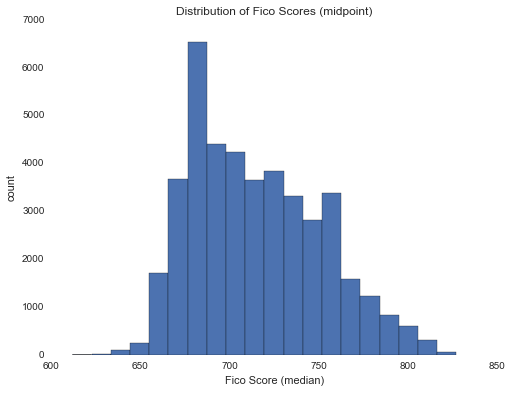

In [14]:
# Define 'fico_interp' as midpoint between fico_range_low and fico_range_high

lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

lcd['fico_interp'].hist(bins=20,figsize=(8, 6))
plt.xlabel('Fico Score (median)')
plt.ylabel('count')
plt.title('Distribution of Fico Scores (midpoint)')

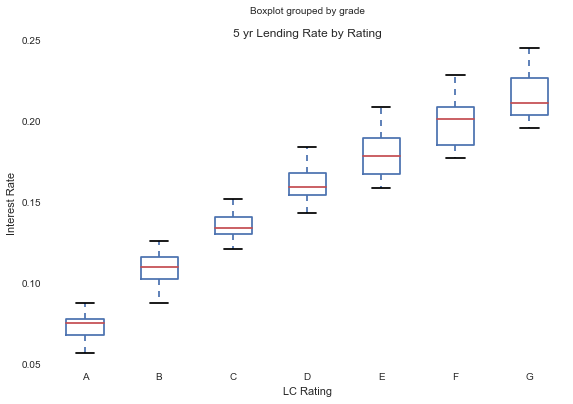

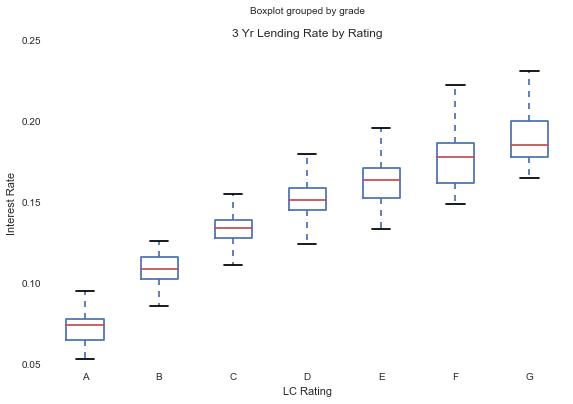

In [15]:
# Make a box chart of historical interest rates per credit grade

# This way is more 'pythonic'
lcd[lcd['clean_term']==60].boxplot(column='clean_rates',by='grade',figsize=(9,6))
plt.xlabel('LC Rating')
plt.ylabel('Interest Rate')
plt.title('5 yr Lending Rate by Rating')

# Old way
# plt.subplot(122)
# lcd_plot3.boxplot(by='grade',figsize=(9, 6))
# More Pythonic
lcd[lcd['clean_term']==36].boxplot(column='clean_rates',by='grade',figsize=(9,6))
plt.xlabel('LC Rating')
plt.ylabel('Interest Rate')
plt.title('3 Yr Lending Rate by Rating')

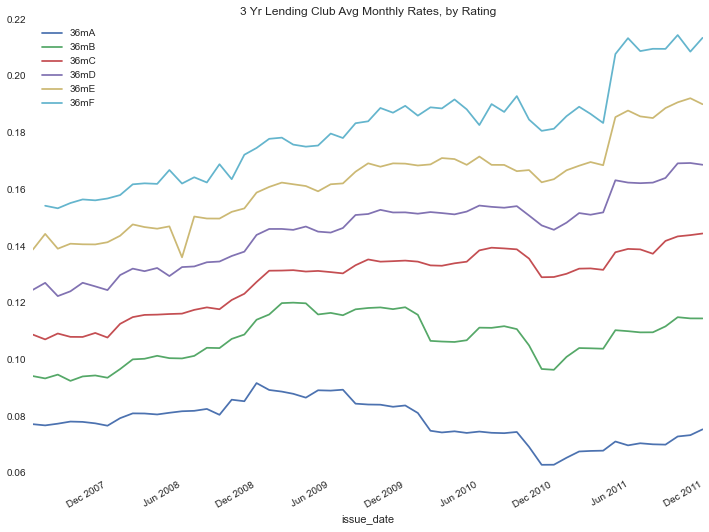

In [16]:
# Now create series of data based upon Grade and Term for loans with term = 36 mos

from itertools import groupby

# First create series for each credit grade
plt_data3_A = lcd[(lcd['grade']=='A') & (lcd['clean_term']==36)].sort()
plt_data3_B = lcd[(lcd['grade']=='B') & (lcd['clean_term']==36)].sort()
plt_data3_C = lcd[(lcd['grade']=='C') & (lcd['clean_term']==36)].sort()
plt_data3_D = lcd[(lcd['grade']=='D') & (lcd['clean_term']==36)].sort()
plt_data3_E = lcd[(lcd['grade']=='E') & (lcd['clean_term']==36)].sort()
plt_data3_F = lcd[(lcd['grade']=='F') & (lcd['clean_term']==36)].sort()

# Mow Create dataframe of monthly average rates from individual series 
data3_F = plt_data3_F.groupby(plt_data3_F.issue_date)['clean_rates'].mean()
data3_E = plt_data3_E.groupby(plt_data3_E.issue_date)['clean_rates'].mean()
data3_D = plt_data3_D.groupby(plt_data3_D.issue_date)['clean_rates'].mean()
data3_C = plt_data3_C.groupby(plt_data3_C.issue_date)['clean_rates'].mean()
data3_B = plt_data3_B.groupby(plt_data3_B.issue_date)['clean_rates'].mean()
data3_A = plt_data3_A.groupby(plt_data3_A.issue_date)['clean_rates'].mean()

# define indices 
d = {'36mA': data3_A, '36mB': data3_B, '36mC': data3_C,'36mD': data3_D, '36mE': data3_E, '36mF': data3_F}
 
# Create new dataframe and plot
df=pd.DataFrame(data=d)
df.plot(figsize=(12,9),title="3 Yr Lending Club Avg Monthly Rates, by Rating")

In [17]:
# Defaults will become our Response variable (y)
# print lcd['loan_status'].unique()
# ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
#  'In Grace Period' 'Late (16-30 days)'
# 'Does not meet the credit policy.  Status:Current'
# 'Does not meet the credit policy.  Status:Charged Off'
# 'Does not meet the credit policy.  Status:Fully Paid'
# 'Does not meet the credit policy.  Status:Late (16-30 days)'
# 'Does not meet the credit policy.  Status:In Grace Period'
# 'Does not meet the credit policy.  Status:Late (31-120 days)']

# Create a calculated feature which simplifies the accounting.   
# Fold anything <30 days delinquent into current
# Fold any other delinquency not defaulted into delinquent
# Fold 'Does not meet the Credit Policy' into similar category for other loans
# Fold 'Charged Off' into 'Default'

# 0 = Fully paid/Current
# 1 = Delinquent
# 2 = Defalt/Charged Off

lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':2,'Current':0,'Default':2,
                            'Late (31-120 days)':1,'In Grace Period':0,'Late (16-30 days)':1,
                            'Does not meet the credit policy.  Status:Current':0,
                            'Does not meet the credit policy.  Status:Charged Off':2,
                            'Does not meet the credit policy.  Status:Fully Paid':0,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':1,
                            'Does not meet the credit policy.  Status:In Grace Period':0,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':1,
                            'Does not meet the credit policy.  Status:Default' :2})                     


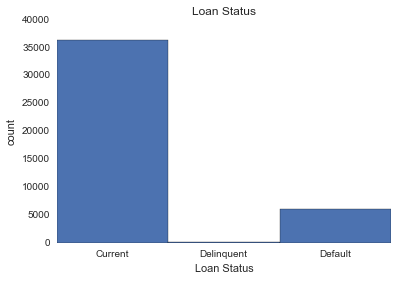

In [18]:
# Convert loan status by using One Hot Encoder (OHE)

ohe = OneHotEncoder(sparse=False)

# THere's only one na, so this shouldn't bias our results tremendously...
lcd['loan_status_int'].fillna(method = 'backfill', inplace= True)

# Use OHE to create multiple features out of loan_status_int
encoded_loan_status = ohe.fit_transform(lcd[['loan_status_int']])

# Create a dataframe to add to lcd
loan_status_columns = ('Current','Delinquent','Default')
encoded_dataframe = pd.DataFrame(encoded_loan_status, columns=loan_status_columns)

# Concat this to lcd. 
lcd = pd.concat([lcd, encoded_dataframe], axis=1)

# Graph the features. 
bar_width = 1.0
x_axis = np.linspace(0,2,num=3)
plt.bar(x_axis,(encoded_dataframe['Current'].sum(),encoded_dataframe['Delinquent'].sum(),
                encoded_dataframe['Default'].sum()),width=bar_width)
plt.xticks(x_axis+bar_width/2,('Current', 'Delinquent', 'Default'))
plt.xlabel('Loan Status')
plt.ylabel('count')
plt.title('Loan Status')

In [19]:
# Create a test and train set from original data
# Select Features and create the feature and target dfs. 

X_Columns = ['fico_interp', 'dti','clean_rates','loan_amnt','mths_since_last_record','mths_since_last_delinq']

# I used concat as performing dropna on the entire dataset would present problems.  
lcd_temp = pd.concat([lcd[X_Columns],lcd['Default']],axis=1).dropna()
X = lcd_temp[X_Columns]
y = lcd_temp['Default']



In [21]:
# Create train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.50,random_state=123)

In [32]:
# Let's try to visualize features correlated to default.
# First, take xtrain, ytrain and create two dataframes depending on default status
# train = pd.DataFrame(Xtrain, columns = X.columns)
# train['default'] = ytrain
# train_nd = train[train['default']==0]
# train_d = train[train['default']==1]
# print Xtrain.shape
# plt.figure(figsize=(12,9))

#  plt.scatter(train_nd.fico_interp, train_nd.dti, alpha= 0.75,marker='+', c= 'b')
# plt.scatter(train_d.fico_interp, train_d.dti, marker='o', edgecolors = 'r', facecolors = 'none')
# plt.legend( ('no default', 'default'), loc='upper right')

In [ ]:
#  We should use feature reduction here to select top features from total.  


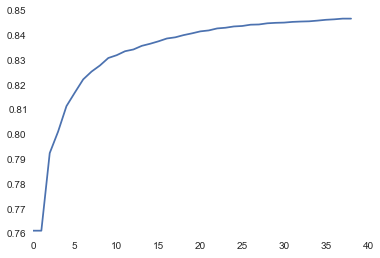

In [35]:
#  Use KNN to start...
from sklearn import neighbors

scores = []
for k in range(1, 40):
    clf = neighbors.KNeighborsClassifier(k, weights='distance')
 
    clf.fit(Xtrain, ytrain);

    scores.append(clf.score(Xtest, ytest))

plt.plot(scores)

ypred = clf.predict(Xtest)


In [37]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(ytest, ypred)
pd.DataFrame(conf_matrix, columns=['Pred ND', 'Pred D'], index=['Actual ND', 'Actual D'])


,Pred ND,Pred D
Actual ND,17919,292
Actual D,2952,63


,fico_interp,dti,clean_rates,loan_amnt,mths_since_last_record,mths_since_last_delinq
count,4.245200e+04,4.245200e+04,4.245200e+04,4.245200e+04,4.245200e+04,4.245200e+04
mean,1.264020e-15,5.992045e-17,-5.623819e-17,1.071204e-16,8.569629e-17,-5.088217e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.848396e+00,-1.988957e+00,-1.818103e+00,-1.429983e+00,-3.484731e+00,-1.388171e+00
25%,-7.759653e-01,-7.681345e-01,-6.853786e-01,-7.956446e-01,3.058695e-01,-1.291358e+00
50%,-8.515522e-02,1.402452e-02,-4.619841e-02,-1.815507e-01,3.058695e-01,7.610729e-01
75%,7.438169e-01,7.887486e-01,6.900724e-01,5.270193e-01,3.058695e-01,7.610729e-01
max,3.092571e+00,2.470539e+00,3.351974e+00,3.226333e+00,3.058695e-01,7.610729e-01


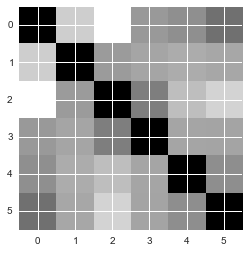

In [22]:
# Create Scaled features and supply to KNN.
from sklearn import preprocessing

scaled_features = preprocessing.scale(X)

# Create new dataframes from scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)
# y = lcd['Default']

plt.imshow(X_scaled.corr(), interpolation='nearest');

## TODO: Scatter matrix plot:
# pd.scatter_matrix(wine_features, c=y, figsize=(20, 20), s=120, cmap='brg');

# Scaler applies 0 mean and unit variance:
X_scaled.describe()

In [ ]:
# Create scaled train and test sets
Xtrain_S, Xtest_S, ytrain, ytest = train_test_split(X_scaled,y,test_size=0.10,random_state=123)

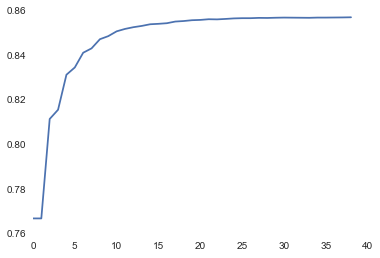

In [39]:
#  Use KNN to start with scaled feature set

scores = []
for k in range(1, 40):
    clf = neighbors.KNeighborsClassifier(k, weights='distance')
 
    clf.fit(Xtrain_S, ytrain);

    scores.append(clf.score(Xtest_S, ytest))

plt.plot(scores)

y_pred = clf.predict(Xtest_S)

In [25]:
#  Calculate a logistic regression against the 2 features for now. 
# Use Cross Validation to create train, test samples from data

import sklearn
import sklearn.linear_model as lm
import sklearn.grid_search as gs

#  Run a logistic regression on the training set to predict y
logreg = lm.LogisticRegression()
logreg.fit(Xtrain_S, ytrain)
print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest_S,ytest)

[[ 0.0371295   0.09103479  0.57072439 -0.10620255 -0.15580842  0.0135798 ]]
[-1.90050647]
0.857556280917


In [26]:
# Let's try to tune some logreg hyperparameters.   
# pipeline with scaling to select best C and penalty

from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

pipe = make_pipeline(preprocessing.StandardScaler(), lm.LogisticRegression())
C_range = 10.**np.arange(-2, 3)
penalty_options = ['l1', 'l2']

skf = StratifiedKFold(y, 3)
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)

grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.654603731978
{'logisticregression__penalty': 'l1', 'logisticregression__C': 0.01}


In [27]:
#  Run a new logistic regression on the training set to predict y
logreg = lm.LogisticRegression(penalty= 'l1',C=0.01)
logreg.fit(Xtrain_S, ytrain)
print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest_S,ytest)

[[-0.00913122  0.0188293   0.42806393  0.         -0.10329218  0.        ]]
[-1.79677575]
0.85775818555


In [28]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

from scipy import interp

In [29]:
print y.shape
print X.shape

(42452,)
(42452, 6)


In [ ]:
###############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves


cv = StratifiedKFold(y, n_folds=3)
classifier = svm.SVC(kernel='linear', probability=True)
classifier.fit(X,y)

# classifier = svm.LinearSVC(probability=True)

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

#for i, (train, test) in enumerate(cv):
#    probas_ = classifier.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
#    print i
#    # Compute ROC curve and area the curve
#    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#    mean_tpr += interp(mean_fpr, fpr, tpr)
#    mean_tpr[0] = 0.0
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, 'k--',
#         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for LC Data')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
import statsmodels.formula.api as smf

kf = sklearn.cross_validation.KFold(n=len(X), n_folds=3, shuffle=True, random_state=1234)
smf.logit('Default ~ fico_interp + dti',lcd_temp).fit()

print results.summary()

print logreg.get_params()
print logreg.coef_
# for train, test in kf:   
#   logreg.fit(X.iloc[train],np.ravel(y.iloc[train]))
#    ypredicted = logreg.predict(X.iloc[test])
#    print logreg.coef_
#    print logreg.score(X.iloc[test],y.iloc[test])
    

# setting alpha to 0 effectively removes the hyperparameter
# results = lmf.fit_regularized(alpha=0)
# print results.summary()
# print np.exp(results.params)

AttributeError: max must be larger than min in range parameter.

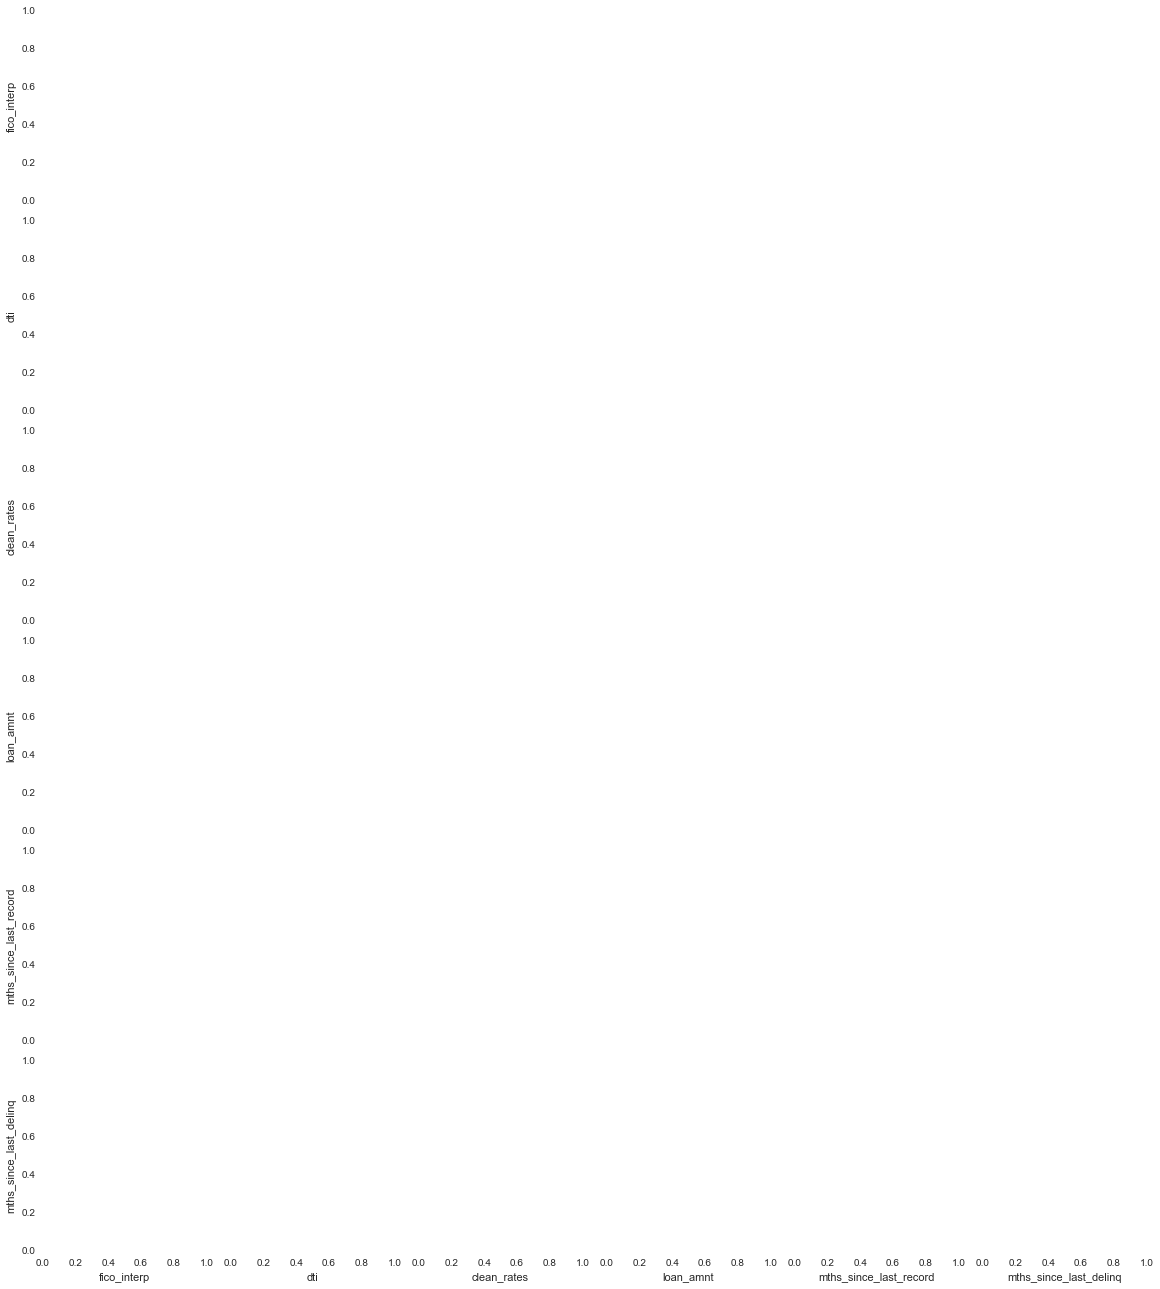

In [131]:
# Scatter plot a subset of certain selected features. 
# convert the 'train' data back into a dataframe
# lcd_small = pd.DataFrame(lcd_temp,columns=lcd_temp.columns)

# pd scatter_matrix doesn't work, but sns does.... why? 
# pd.scatter_matrix(lcd_small[['loan_amnt', 'funded_amnt','int_rate']], figsize=(18, 18), alpha=0.05, diagonal='kde')
sns.pairplot(data=lcd_temp, aspect=0.90, dropna=True)